# Clustering graph into k definite subsets
<img src="image.png">
 


## Graph reader and Graph classes
**We are going to define graph classes to read any input graph**

In [1]:
# Graph class

import numpy as np

class Node:
    def __init__(self, id):
        self.id = id

    def get_id(self):
        return self.id
    
class Edge:
    def __init__(self, source, dest):
        self.source = source
        self.dest = dest

class Graph:

    def __init__(self, num_of_nodes):
        self.num_of_nodes = num_of_nodes
        self.nodes = []
        self.edges = []
        for i in range(num_of_nodes):
            self.nodes.append(Node(i))
        self.adjacent_list = [[] for i in range(num_of_nodes)]
        self.adjacent_list_transpose = [[] for i in range(num_of_nodes)]

    def get_node(self, id):
        """
        :param id:
        :return: The object Node with the given id
        """
        return self.nodes[id]

    def add_edge(self, edge):
        self.edges.append(edge)
        self.adjacent_list[edge.source.id].append(edge.dest)
        self.adjacent_list_transpose[edge.dest.id].append(edge.source)

    def get_adjacent_nodes(self, node):
        return self.adjacent_list[node.id]

    def get_adjacent_nodes_transpose(self, node):
        return self.adjacent_list_transpose[node.id]
    
    def get_D_matrix(self):
        # sum row-wise elements of Adjacency matrix
        D = np.zeros((len(self.nodes), len(self.nodes)))
        
        for i in range(len(self.nodes)):
            D[i][i] = len(self.get_adjacent_nodes(Node(i)))
            
        return D
    
    def get_A_matrix(self):
        A = np.zeros((len(self.nodes), len(self.nodes)))
        
        for node in self.nodes:
            for neigh in self.get_adjacent_nodes(node):
                A[node.id][neigh.id] = 1
            
        return A


In [2]:
# Graph Reader 
import networkx as nx
import numpy as np

class GraphReader():
    def __init__(self, path, is_undirected=True):
        self.path = path
        self.is_undirected = is_undirected
        self.dict_inv = {}
        self.nx_graph = nx.Graph()
        self.node_size = 0

    def read_graph(self):
        """
        Dataset is in txt each line is in the format "id_src, id_dst"
        :return:
        """
        filename = self.path
        edges = []
        with open(filename) as f:
            for line in f:
                edges.append([int(n) for n in line.strip().split(",")[:2]])

        nodes = []
        for e in edges:
            nodes.append(e[0])
            nodes.append(e[1])

        nodes = list(set(nodes))
        self.nx_graph.add_nodes_from(list(np.arange(len(nodes))))
        self.node_size = len(nodes)
        
        # Create mapping with ids from 0 to len(set(nodes)) -1
        new_id = 0
        dict_nodes_id = {}
        for el in list(set(nodes)):
            dict_nodes_id[el] = new_id
            self.dict_inv[new_id] = el
            new_id+=1

        myGraph = Graph(len(nodes))
        for el in edges:#[:-1]:
            curr_edge = Edge(Node(dict_nodes_id[el[0]]), Node(dict_nodes_id[el[1]]))
            myGraph.add_edge(curr_edge)
            self.nx_graph.add_edge(curr_edge.source.id, curr_edge.dest.id)

            if self.is_undirected:
                curr_edge_inv = Edge(Node(dict_nodes_id[el[1]]), Node(dict_nodes_id[el[0]]))
                myGraph.add_edge(curr_edge_inv)
                #self.nx_graph.add_edge(curr_edge_inv.source, curr_edge_inv.dest)

        return myGraph



# Import data and start the analysis
**We will sequentially perform the analysis for the 2 given graphs in the files**
- example1.txt (1966, data collected by Coleman, Katz and Menzel on medical innovation)
- example2.txt (synthetic graph)

In [3]:
path = "example1.txt"
graph_reader = GraphReader(path)
graph = graph_reader.read_graph()

In [4]:
import numpy as np
from sklearn.preprocessing import normalize

# Defining parameters
noise = 1
A = graph.get_A_matrix()
D = graph.get_D_matrix()
X = normalize(A, norm='l1')

## Adjacency and Diagram matrices (A and D)
**That's how they look like for us:**

In [5]:
print("A",A)
print("D",D)

A [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
D [[14.  0.  0. ...  0.  0.  0.]
 [ 0. 18.  0. ...  0.  0.  0.]
 [ 0.  0. 22. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4.  0.  0.]
 [ 0.  0.  0. ...  0. 16.  0.]
 [ 0.  0.  0. ...  0.  0.  4.]]


In [6]:
from numpy.linalg import matrix_power
D_1_2 = D.copy()
for i in range(len(D)):
    D_1_2[i][i] = D_1_2[i][i]**(-0.5)
print(D_1_2)

[[0.26726124 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23570226 0.         ... 0.         0.         0.        ]
 [0.         0.         0.21320072 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.25       0.        ]
 [0.         0.         0.         ... 0.         0.         0.5       ]]


In [7]:
# Our laplacian as D^-0.5 dot A dot D^-0.5
L_temp = np.dot(D_1_2, A)
L = np.dot(L_temp, D_1_2)
print(L)

[[0.         0.06299408 0.05698029 ... 0.         0.         0.        ]
 [0.06299408 0.         0.         ... 0.         0.         0.        ]
 [0.05698029 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [8]:
# Eigenpair
from numpy import linalg as LA
eigenval, eigenvect = LA.eig(L)
eigenpairs = [[eigenval[i], list(eigenvect[:,i])] for i in range(len(eigenval))]

eigenpairs.sort(key=lambda x: x[0])
eigenpairs = eigenpairs[::-1]
eigenval = [x[0] for x in eigenpairs]
eigenvect = [x[1] for x in eigenpairs]


print("Biggest 10 eigenvalues are", eigenval[:10])

Biggest 10 eigenvalues are [0.4361603135424426, 0.43149123073341555, 0.4208731189567617, 0.40643213062148653, 0.38632090444664124, 0.3437744690739979, 0.331098763919728, 0.3277063361369134, 0.32269718121415353, 0.31985031328773955]


In [9]:
# Find the k value by maximizing the eigengap:
def find_best_k(eigenvals):
    k = 0
    gap = 0
    gaps = []
    for i in range(1,len(eigenvals)):
        curr_gap = eigenvals[i-1]-eigenvals[i]
        if curr_gap > gap:
            k = i
            gap = curr_gap
        gaps.append((i, curr_gap))

    gaps.sort(key=lambda x: x[1], reverse=True)
    print("Largest 3 gaps and their respective clusters:", gaps[:3] )
    return k

## Graph spectra: we are going to print the eigenvalues sorted

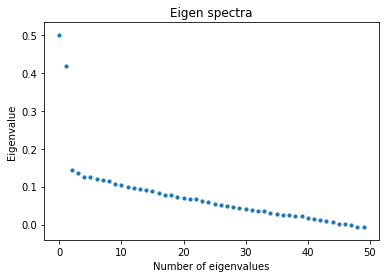

In [19]:
# PLOT eigenvalues
import matplotlib.pyplot as plt
# x axis value list.
x_number_list = list(range(len(eigenval)))[:50]

# y axis value list.
y_number_list = eigenval[:50]

# Draw point based on above x, y axis values.
plt.scatter(x_number_list, y_number_list, s=10)

# Set chart title.
plt.title("Eigen spectra")

# Set x, y label text.
plt.xlabel("Number of eigenvalues")
plt.ylabel("Eigenvalue")
plt.show()

In [11]:
# get matrix X of largest k eigenvalues' eigenvectors
from operator import itemgetter

k = find_best_k(list(map(itemgetter(0), eigenpairs)))
print("Best found k is", k)
X = np.array(eigenvect[:k]).T
Y = normalize(X, norm='l2')

Largest 3 gaps and their respective clusters: [(10, 0.04510354047640186), (5, 0.042546435372643354), (4, 0.020111226174845287)]
Best found k is 10


### Print the found clusters

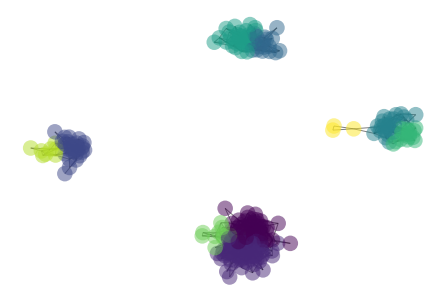

In [12]:
# K-means
from sklearn.cluster import KMeans
import numpy as np

n_clusters = k
kmeans = KMeans(n_clusters=n_clusters , random_state=0).fit(Y)
nx.draw(graph_reader.nx_graph, node_size = graph_reader.node_size, node_color = kmeans.labels_, with_lables = True, alpha=0.5, edge_color="black", linewidths = 0.01)

In [13]:
nodes_with_clusters = kmeans.predict(Y)

clusters = [[] for i in range(n_clusters )]
for i in range(len(nodes_with_clusters)):
    clusters[nodes_with_clusters[i]].append(graph_reader.dict_inv[i])
print(clusters)

[[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 38, 39, 40, 41, 42, 45, 53, 58, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 82, 83, 85, 88, 89, 90, 91, 94, 98, 101, 102, 103, 108, 110], [4, 13, 14, 15, 16, 17, 18, 19, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 74, 76, 79, 80, 81, 84, 86, 87, 92, 96, 97, 99, 100, 104, 105, 106, 107, 109, 113, 114, 116], [207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 233, 234, 235, 240, 241], [118, 119, 120, 121, 122, 123, 124, 125, 126, 135, 136, 137, 142, 143, 160, 161, 162], [166, 167, 168, 169, 171, 172, 174, 175, 176, 177, 179, 187, 190, 194, 196, 197, 198, 199, 200, 201, 203, 205, 206], [127, 128, 129, 130, 131, 132, 133, 134, 138, 139, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 163, 164, 165], [170, 173, 182, 183, 184, 185, 186, 188, 189, 191, 192, 193, 195, 202, 2

In [14]:
current_cluster = clusters[-3] # cluster having 3 elements
for i in range(len(clusters)):
    current_cluster = clusters[i]
    edges_curr = []
    for edge in graph.edges:
        if edge.source.id in current_cluster or edge.dest.id in current_cluster:
            edges_curr.append((edge.source.id, edge.dest.id))

    #print(edges_curr)
    internal_connections = 0
    external_connections = 0
    for edge in edges_curr:
        if edge[0] in current_cluster and edge[1] in current_cluster:
            internal_connections +=1
        else:
            external_connections +=1
    print("Cluster", i)
    print("Internal connections:", internal_connections)
    print("External connections:", external_connections)
    print()

Cluster 0
Internal connections: 448
External connections: 876

Cluster 1
Internal connections: 624
External connections: 940

Cluster 2
Internal connections: 440
External connections: 192

Cluster 3
Internal connections: 188
External connections: 348

Cluster 4
Internal connections: 164
External connections: 404

Cluster 5
Internal connections: 304
External connections: 376

Cluster 6
Internal connections: 108
External connections: 348

Cluster 7
Internal connections: 12
External connections: 352

Cluster 8
Internal connections: 52
External connections: 168

Cluster 9
Internal connections: 0
External connections: 72



As we can notice, many clusters are disconnected, and internally to these disconnected clusters, we can identify other communities. That is not strange, if we check for the connections of these nodes, we find that their internal connections are more than external, i.e. makes sense to be considered as clusters.
# 2 - Synthetic graph example2 

In [15]:
path = "example2.txt"
graph_reader = GraphReader(path, True)
graph = graph_reader.read_graph()

[[0.         0.02528609 0.         ... 0.         0.         0.        ]
 [0.02528609 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.02378257 0.02044652 0.01706972]
 ...
 [0.         0.         0.02378257 ... 0.         0.         0.        ]
 [0.         0.         0.02044652 ... 0.         0.         0.01814885]
 [0.         0.         0.01706972 ... 0.         0.01814885 0.        ]]
Biggest 10 eigenvalues are [0.4999999999999991, 0.4172142392533188, 0.1446699561791223, 0.13532777891937947, 0.12666903212991457, 0.12456951726769366, 0.11968178821561895, 0.118301153492255, 0.11360731112534717, 0.10683127990978561]


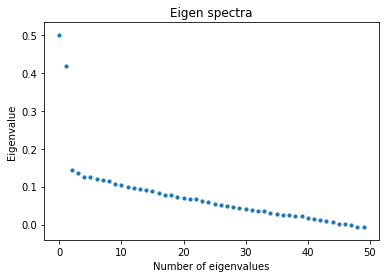

Largest 3 gaps and their respective clusters: [(2, 0.27254428307419654), (1, 0.08278576074668031), (98, 0.011991480627691176)]
Best found k is 2


In [16]:
# Defining parameters
noise = 1
A = graph.get_A_matrix()
D = graph.get_D_matrix()
X = normalize(A, norm='l1')

D_1_2 = D.copy()
for i in range(len(D)):
    D_1_2[i][i] = D_1_2[i][i]**(-0.5)
    
# Our laplacian as D^-0.5 dot A dot D^-0.5
L_temp = np.dot(D_1_2, A)
L = np.dot(L_temp, D_1_2)
print(L)

from numpy import linalg as LA
eigenval, eigenvect = LA.eig(L)
eigenpairs = [[eigenval[i], list(eigenvect[:,i])] for i in range(len(eigenval))]

eigenpairs.sort(key=lambda x: x[0])
eigenpairs = eigenpairs[::-1]
eigenval = [x[0] for x in eigenpairs]
eigenvect = [x[1] for x in eigenpairs]


print("Biggest 10 eigenvalues are", eigenval[:10])

# PLOT eigenvalues
import matplotlib.pyplot as plt
# x axis value list.
x_number_list = list(range(len(eigenval)))[:50]

# y axis value list.
y_number_list = eigenval[:50]

# Draw point based on above x, y axis values.
plt.scatter(x_number_list, y_number_list, s=10)

# Set chart title.
plt.title("Eigen spectra")

# Set x, y label text.
plt.xlabel("Number of eigenvalues")
plt.ylabel("Eigenvalue")
plt.show()

# get matrix X of largest k eigenvalues' eigenvectors
from operator import itemgetter

k = find_best_k(list(map(itemgetter(0), eigenpairs)))
print("Best found k is", k)
X = np.array(eigenvect[:k]).T
Y = normalize(X, norm='l2')

The eigengap technique for detecting the best k outputs k=2, hence, the cluster seems to be well connected and doesn't detect presence of many communities. Let's print the clusters

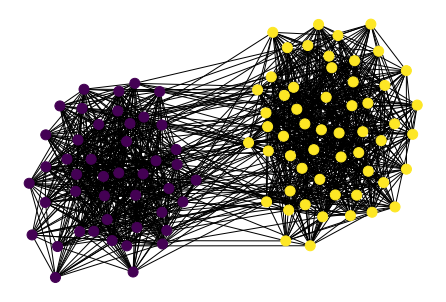

In [17]:
n_clusters = k
kmeans = KMeans(n_clusters=n_clusters , random_state=0).fit(Y)
nodes_with_clusters = kmeans.predict(Y)

nx.draw(graph_reader.nx_graph, node_size = graph_reader.node_size, node_color = kmeans.labels_, with_lables = True)

In [18]:
clusters = [[] for i in range(n_clusters )]
for i in range(len(nodes_with_clusters)):
    clusters[nodes_with_clusters[i]].append(graph_reader.dict_inv[i])
print(clusters)

[[3, 6, 7, 11, 14, 16, 17, 22, 28, 30, 32, 33, 34, 35, 38, 40, 41, 42, 45, 46, 47, 51, 54, 55, 58, 60, 62, 68, 69, 70, 72, 74, 76, 77, 78, 80, 81, 86, 89, 91, 92, 96, 98, 99, 100], [1, 2, 4, 5, 8, 9, 10, 12, 13, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 31, 36, 37, 39, 43, 44, 48, 49, 50, 52, 53, 56, 57, 59, 61, 63, 64, 65, 66, 67, 71, 73, 75, 79, 82, 83, 84, 85, 87, 88, 90, 93, 94, 95, 97]]
